<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#tl;dr" data-toc-modified-id="tl;dr-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>tl;dr</a></span></li><li><span><a href="#setup" data-toc-modified-id="setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#data" data-toc-modified-id="data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#neural-network-architecture" data-toc-modified-id="neural-network-architecture-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>neural network architecture</a></span><ul class="toc-item"><li><span><a href="#training" data-toc-modified-id="training-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>training</a></span></li><li><span><a href="#results" data-toc-modified-id="results-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>results</a></span></li></ul></li></ul></div>

# tl;dr

in this notebook we will try to estimate the parameters of the **newton's law of cooling** (nlc) using a physics-informed neural network (pinn). we will compare the results with that obtained using a simple ordinary least squares (ols) regression.

# setup

In [1]:
import os
# import pprint
# import functools
import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import torch
import torch.nn as nn
import torch.optim as optim

# import optuna

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from IPython.display import display

%matplotlib inline

In [2]:
mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['text.usetex'] = True

experiment_name = 'nlc_with_param_learning'

folder_path = f"../data/08_reporting/{experiment_name}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

golden_ratio = (np.sqrt(5) - 1) / 2

# data

<!-- **medidas** <br/> de [Lab 6: Simple Harmonic Oscillators](https://www.studocu.com/en-us/document/the-city-college-of-new-york/general-physics-i/lab-6-simple-harmonic-oscillators/27226380)

| $Time(s)$ | $Position (m)$ | $Velocity (m s^{-1})$ | Acceleration ($m s^{-2}$) |
|:-----------:|:---------------:|:-----------------:|:-----------------------:|
|      0      |     0.181104    |     -0.003521     |        0.0107877        |
|     0.5     |    0.1808296    |      -0.00048     |        -0.016009        |
|      1      |    0.1808296    |     0.0563435     |        0.9898961        |
|     1.5     |    0.2458624    |     0.0782269     |         1.068586        |
|      2      |     0.208544    |     -0.279888     |         0.698207        |
|     2.5     |    0.1808296    |     0.0872821     |        1.2009078        |
|      3      |     0.297724    |     0.0721215     |         -1.22394        |

Spring Constant: k = 16.16
Length of Spring: 0.18m
Length of Spring (Stretched): 0.787m
X= 0.607 

data = [
    [0, 0.181104, -0.003521, 0.0107877],
    [0.5, 0.1808296, -0.00048, -0.016009],
    [1, 0.1808296, 0.0563435, 0.9898961],
    [1.5, 0.2458624, 0.0782269, 1.068586],
    [2, 0.208544, -0.279888, 0.698207],
    [2.5, 0.1808296, 0.0872821, 1.2009078],
    [3, 0.297724, 0.0721215, -1.22394]
]

pd.DataFrame(data, columns=["t", "x", "v", "a"])
-->

**medidas** <br/> [Newton's Law of Cooling](https://qcpages.qc.cuny.edu/~zakeri/mat158/cooling.html)

$$ \frac{dT}{dt} = k (T-S) $$ 

where $k<0$ is a constant. 

$$ T=(T_0-S) e^{kt} + S \qquad \qquad  $$

where $T_0$ is the initial temperature.

,time,temperature
0,0,182.0
1,10,151.7
2,20,133.9
3,30,122.0
4,40,113.1
5,50,106.2
6,60,101.1
7,70,96.7
8,80,93.5
9,90,90.9


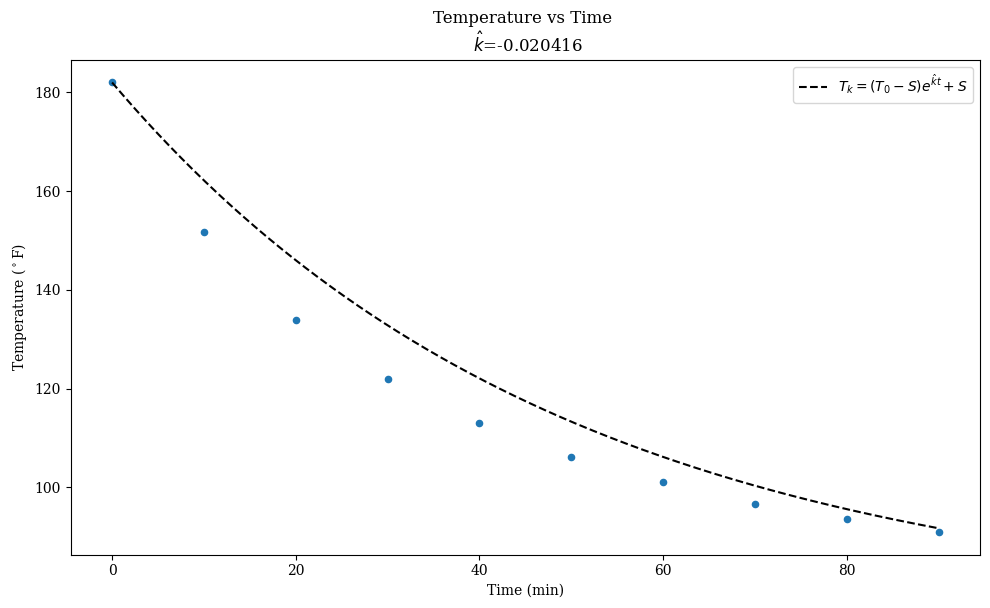

In [3]:
data = [
    [0,	10,	20,	30,	40,	50,	60,	70,	80,	90],
    [182.0,	151.7,	133.9,	122.0,	113.1,	106.2,	101.1,	96.7,	93.5,	90.9],
]
S = 74.6
k = -0.020416

X = pd.DataFrame(data).T.rename(columns={0: 'time', 1: 'temperature'}).astype({'time': int})

display(X)
X.to_parquet(f"{folder_path}/experimental_data.parquet")

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, golden_ratio*10))

X.plot.scatter(x='time', y='temperature', ax=ax1)

t = np.linspace(0, 90, 1000)
T = (X['temperature'][0] - S) * np.exp(k * t) + S

ax1.plot(
    t,
    T, 
    c="k", linestyle="--",
    label="$T_k=(T_0-S) e^{\hat{k}t} + S$",
) 

ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Temperature ($^\circ$F)")
ax1.set_title("Temperature vs Time \n $\hat{k}$=-0.020416")

plt.legend()
plt.tight_layout()

plt.savefig(f"{folder_path}/temperature_vs_time.png", dpi=300)

In [4]:
# min_max_scaler = MinMaxScaler()

# minmax_X = pd.DataFrame(min_max_scaler.fit_transform(X)).rename(columns={0: 'time', 1: 'temperature'})
# minmax_S = min_max_scaler.transform([[0, S]])[0][1]

# display(minmax_X)
# print(minmax_S)

In [5]:
train_test_threshold = 90

In [6]:
torch.manual_seed(33)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train = torch.tensor(X.query(f"time <= {train_test_threshold}")["time"].values).float().unsqueeze(1).to(device)
y_train = torch.tensor(X.query(f"time <= {train_test_threshold}")["temperature"].values).float().unsqueeze(1).to(device)

x_test = torch.tensor(X.query(f"time > {train_test_threshold}")["time"].values).float().unsqueeze(1).to(device)
y_test = torch.tensor(X.query(f"time > {train_test_threshold}")["temperature"].values).float().unsqueeze(1).to(device)

# neural network architecture

In [7]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

torch.manual_seed(33) ;

In [13]:
hparam_dict = {
    'learning_rate': 1e-3,
    'n_layers': 4,
    'n_neurons': 32,
    'num_epochs': 25000,
 }

learning_rate = hparam_dict["learning_rate"]
num_epochs = hparam_dict["num_epochs"]
architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]

## training

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)


  0%|          | 0/25000 [00:00<?, ?it/s]/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 29/25000 [00:00<01:28, 282.65it/s]

  4%|▍         | 1044/25000 [00:03<01:19, 303.23it/s]

Data Loss: 2.148606, Physics Loss: 301.869812, T0 Loss: 0.005912, Total Loss: 5.167363
k: 0.311012


  8%|▊         | 2049/25000 [00:08<01:30, 252.79it/s]

Data Loss: 0.713660, Physics Loss: 31.322420, T0 Loss: 0.000031, Total Loss: 1.026884
k: -0.006838


 12%|█▏        | 3048/25000 [00:12<01:28, 247.97it/s]

Data Loss: 0.325501, Physics Loss: 24.639597, T0 Loss: 0.000000, Total Loss: 0.571897
k: -0.048944


 16%|█▌        | 4040/25000 [00:15<01:21, 257.18it/s]

Data Loss: 0.296733, Physics Loss: 21.757181, T0 Loss: 0.000028, Total Loss: 0.514305
k: -0.047456


 20%|██        | 5035/25000 [00:19<01:24, 235.06it/s]

Data Loss: 0.282138, Physics Loss: 19.024738, T0 Loss: 0.000113, Total Loss: 0.472386
k: -0.043931


 24%|██▍       | 6066/25000 [00:22<00:53, 356.15it/s]

Data Loss: 0.278860, Physics Loss: 15.204059, T0 Loss: 0.000072, Total Loss: 0.430902
k: -0.044689


 28%|██▊       | 7031/25000 [00:25<01:11, 250.90it/s]

Data Loss: 1.398843, Physics Loss: 11.734461, T0 Loss: 0.005975, Total Loss: 1.516248
k: -0.039595


 32%|███▏      | 8038/25000 [00:29<00:55, 307.70it/s]

Data Loss: 0.276776, Physics Loss: 10.902793, T0 Loss: 0.000046, Total Loss: 0.385804
k: -0.040349


 36%|███▌      | 9030/25000 [00:33<01:03, 253.08it/s]

Data Loss: 0.806728, Physics Loss: 8.915396, T0 Loss: 0.002560, Total Loss: 0.895907
k: -0.038032


 40%|████      | 10036/25000 [00:37<01:02, 241.15it/s]

Data Loss: 0.276433, Physics Loss: 6.465806, T0 Loss: 0.000035, Total Loss: 0.341092
k: -0.036585


 44%|████▍     | 11044/25000 [00:41<00:54, 255.55it/s]

Data Loss: 0.276442, Physics Loss: 3.445259, T0 Loss: 0.000019, Total Loss: 0.310895
k: -0.032038


 48%|████▊     | 12040/25000 [00:44<00:50, 257.16it/s]

Data Loss: 0.276499, Physics Loss: 1.740470, T0 Loss: 0.000008, Total Loss: 0.293903
k: -0.029193


 52%|█████▏    | 13051/25000 [00:48<00:43, 275.08it/s]

Data Loss: 0.310054, Physics Loss: 0.909055, T0 Loss: 0.000021, Total Loss: 0.319144
k: -0.025666


 56%|█████▌    | 14040/25000 [00:51<00:37, 295.41it/s]

Data Loss: 1.396072, Physics Loss: 0.245767, T0 Loss: 0.004142, Total Loss: 1.398571
k: -0.025090


 60%|██████    | 15055/25000 [00:54<00:27, 365.98it/s]

Data Loss: 0.276430, Physics Loss: 0.254634, T0 Loss: 0.000000, Total Loss: 0.278976
k: -0.022456


 64%|██████▍   | 16041/25000 [00:57<00:28, 310.16it/s]

Data Loss: 0.276539, Physics Loss: 0.256451, T0 Loss: 0.000001, Total Loss: 0.279104
k: -0.021202


 68%|██████▊   | 17030/25000 [01:00<00:24, 331.76it/s]

Data Loss: 0.599430, Physics Loss: 0.171425, T0 Loss: 0.003350, Total Loss: 0.601178
k: -0.023056


 72%|███████▏  | 18027/25000 [01:04<00:26, 258.68it/s]

Data Loss: 0.276418, Physics Loss: 0.157800, T0 Loss: 0.000000, Total Loss: 0.277996
k: -0.022897


 76%|███████▌  | 19029/25000 [01:07<00:20, 289.29it/s]

Data Loss: 0.149507, Physics Loss: 0.289923, T0 Loss: 0.000001, Total Loss: 0.152406
k: -0.020287


 80%|████████  | 20029/25000 [01:11<00:19, 252.51it/s]

Data Loss: 0.153919, Physics Loss: 0.198345, T0 Loss: 0.000055, Total Loss: 0.155903
k: -0.021472


 84%|████████▍ | 21050/25000 [01:15<00:15, 254.92it/s]

Data Loss: 0.152316, Physics Loss: 0.167115, T0 Loss: 0.000006, Total Loss: 0.153987
k: -0.022179


 88%|████████▊ | 22048/25000 [01:19<00:11, 254.32it/s]

Data Loss: 2.380489, Physics Loss: 0.152919, T0 Loss: 0.022889, Total Loss: 2.382247
k: -0.022362


 92%|█████████▏| 23035/25000 [01:22<00:06, 326.84it/s]

Data Loss: 0.149143, Physics Loss: 0.140470, T0 Loss: 0.000010, Total Loss: 0.150548
k: -0.021224


 96%|█████████▋| 24074/25000 [01:25<00:02, 416.70it/s]

Data Loss: 0.149620, Physics Loss: 0.135253, T0 Loss: 0.000000, Total Loss: 0.150972
k: -0.021614


100%|██████████| 25000/25000 [01:27<00:00, 285.08it/s]


Data Loss: 0.205499, Physics Loss: 0.134504, T0 Loss: 0.000341, Total Loss: 0.206847
k: -0.021863


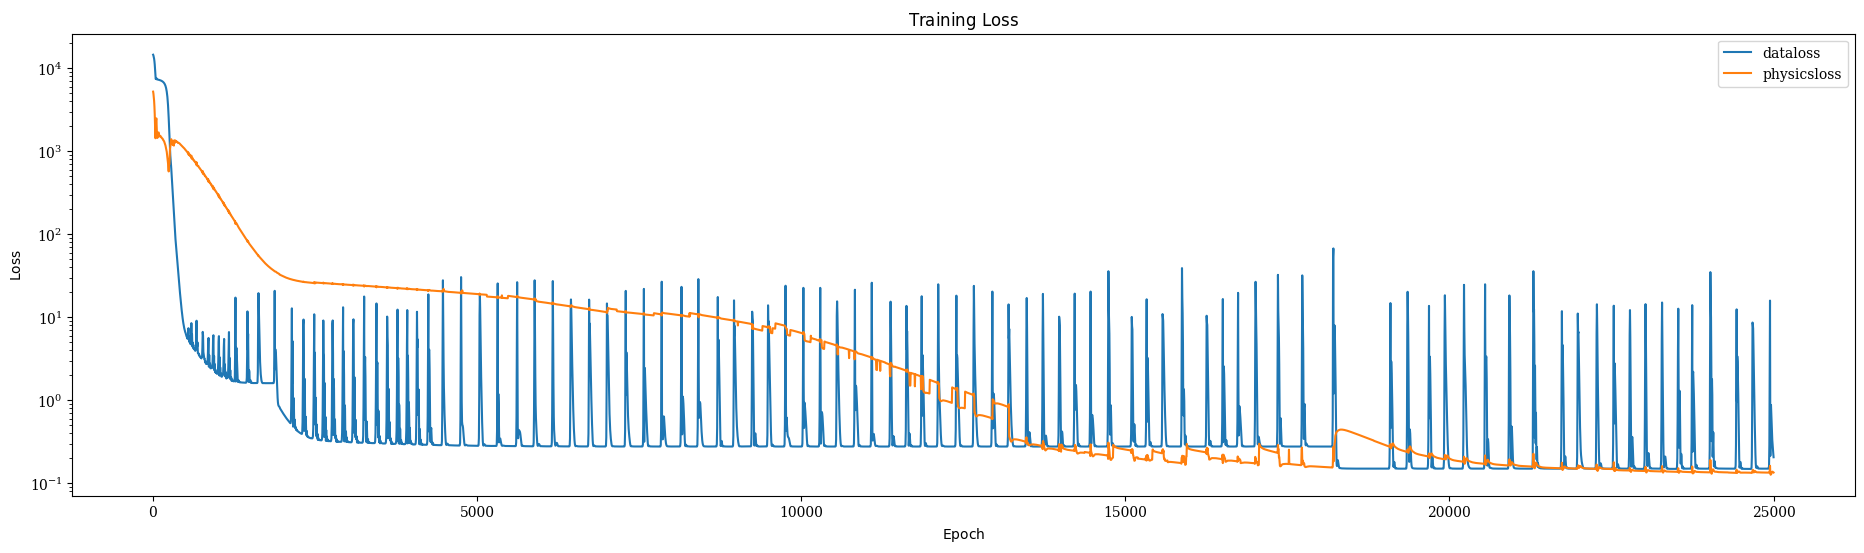

In [14]:
_locations = torch.linspace(0, 90, 45).view(-1,1).requires_grad_(True).to(device)
_S = torch.tensor(S, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(1.0, dtype=torch.float, requires_grad=True, device=device)
_T0 = torch.tensor(X["temperature"][0], dtype=torch.float, requires_grad=False).to(device)

model = MultiLayerPerceptronRegressor(architecture, nn.LeakyReLU)
model.to(device)
optimizer = optim.Adam([
    {"params": model.parameters()}, 
    {"params": [_k]}
], lr=learning_rate)
criterion = nn.MSELoss()

print(model)

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[])

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    optimizer.zero_grad()

    # forward
    y_train_hat = model(x_train)
    data_loss = criterion(y_train_hat, y_train)

    y_location_hat = model(_locations)
    dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]

    _diff_equation = dydt - _k * (y_location_hat - _S)

    physics_loss = torch.mean(_diff_equation**2)
    _T0_loss = criterion(y_location_hat[0], _T0)

    loss = data_loss + (1e-2)*(physics_loss + _T0_loss)
    
    # backward
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        str_physics_loss = str(round(physics_loss.item(), 4))
        # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
        print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, T0 Loss: {_T0_loss.item():.6f}, Total Loss: {loss.item():.6f}")
        print(f"k: {_k.item():.6f}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["dataloss"].append(data_loss.item())
        plot_loss_train["physicsloss"].append(physics_loss.item())

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

pd.DataFrame(plot_loss_train).plot(x="epoch", y="dataloss", figsize=(23, 6), ax=ax1)
pd.DataFrame(plot_loss_train).plot(x="epoch", y="physicsloss", figsize=(23, 6), ax=ax1)
ax1.set_xlabel(r"$\mathrm{Epoch}$")
ax1.set_ylabel(r"$\mathrm{Loss}$")
ax1.set_title(r"$\mathrm{Training}$ $\mathrm{Loss}$")

ax1.set_yscale('log')

pd.DataFrame(x_train.cpu().numpy(), columns=["time"]).to_parquet(f"{folder_path}/x_train.parquet")
pd.DataFrame(y_train.cpu().numpy(), columns=["temperature"]).to_parquet(f"{folder_path}/y_train.parquet")

In [47]:
torch.save(model, f"{folder_path}/pinn_model.pth")
torch.save(model.state_dict(), f"{folder_path}/pinn_weights.pth")

## results

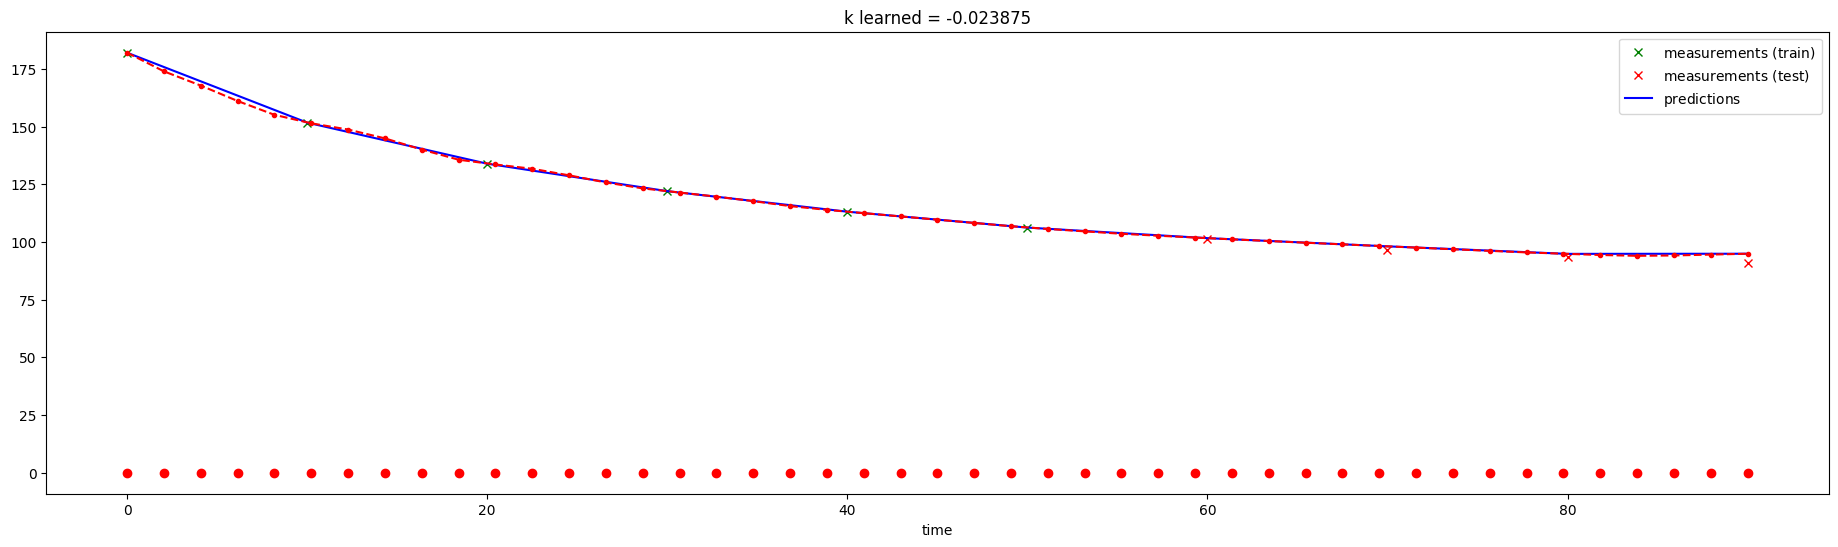

In [12]:
model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.query(f"time <= {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query(f"time > {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"$\text{predictions}$"
) 

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o",
    label=r"$\text{locations}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".",
    label=r"$\text{locations prediction}$"
) 

plt.title(f"k learned = {_k.item():.6f}") ;

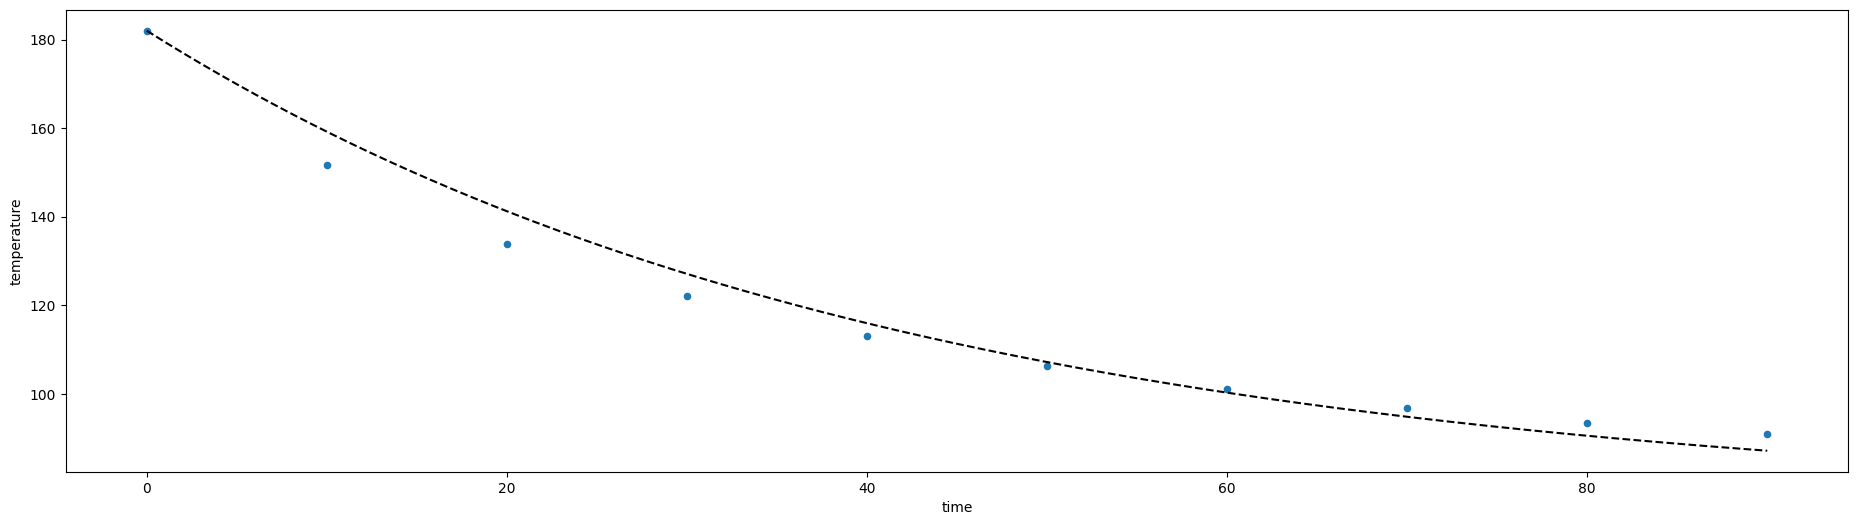

In [13]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.plot.scatter(x='time', y='temperature', ax=ax1)

t = np.linspace(0, 90, 1000)
T = (X['temperature'][0] - S) * np.exp(_k.item() * t) + S

ax1.plot(
    t,
    T, 
    c="k", linestyle="--",
    label="Theoretical model"
) ;

.